[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MauricioRR-Tec/AprendizajeAutomatico/blob/master/Tema_3_Preprocesamiento/notebook/03FromReg2ClasswAns.ipynb)

# Algoritmos Clásicos de ML con ``Scikit Learn``

<img src="https://docs.google.com/uc?export=download&id=1CIfbX5jBvNjuSQnJechEvnawuMEa5QTq" width="300" align="middle">

---

## Contenido de la Sesión


1. Regresión con otros Algoritmos
          1.1. Selección de Variables: Filtros.
            1.1.1. Menor Varianza.
            1.1.2. Univariable.
          1.2. Selección de Variables: Envoltorios.
            1.2.1. Eliminación Recursiva.
          1.3. Validación Cruzada (CV).
          1.4. Predicción.
          1.5. Análisis de Resultados.

2. Clasificación Binaria.
          2.0. Conjuntos de datos sintéticos
          2.1. Clasificadores RL/KNN/DT
            - Evaluación de Clasificadores
          2.2. CV para
            2.2.1. Selección de Variables Recursiva.
            2.2.2. Sintonización de parámetros.

---
# 1. Regresión con otros Algoritmos

### Comparación de Regresores (LRM vs KNN vs DT) usando el caso de Generación de Energía para un Generador de Ciclo Combinado

### Inicialización del Modelo usando ``Pipelines``

<img src="https://docs.google.com/uc?export=download&id=1D4d8y7ENGmDwt-rcbs28p1NoQ2LpFSsk" width="800" align="middle">

**Pensamiento de Programador**:

Dentro de un ``pipeline``, para manipular los parámetros del modelo o para obtener el nombre de las variables utilizadas por modelo al aplicarle ``PolynomialFeatures``, conveniene más crear una **instancia por cada estimador**.

Secuencia de Pasos para el PP/Creación de Variables:

    Paso 1: ajustar el "escalador" al conjunto de ENTRENAMIENTO.
    Paso 2: use el "escalador" para transformar el conjunto de ENTRENAMIENTO.
    Paso 3: use el conjunto de ENTRENAMIENTO transformado para entrenar el modelo con la función ``fit``.
    Paso 4: use el "escalador" para transformar el conjunto de PRUEBA.
    Paso 5: prediga usando el modelo entrenado y el conjunto de PRUEBA transformado.

In [1]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from sklearn.pipeline import make_pipeline

import numpy as np
import pandas as pd

#--------
### LOAD DATA 

url = 'https://raw.githubusercontent.com/MauricioRR-Tec/AprendizajeAutomatico/main/Tema_3_Preprocesamiento/data/PowerGeneration/Folds5x2_pp.csv'
ccpp_df = pd.read_csv(url)

#--------
### CREATE PIPELINES
no_poly = 5

std_sclr = StandardScaler()
sclr_01 = MinMaxScaler()

lr_m  = LinearRegression()
knn_m = KNeighborsRegressor(n_neighbors=5)
dt_m  = DecisionTreeRegressor(criterion='mse',
                             max_depth=5,
                             min_samples_split = 20, 
                            #  min_samples_leaf = 10, 
                             random_state=0)

polyFt_m = PolynomialFeatures(no_poly)

#--------
### SPLIT DATA INTO TRAIN AND TEST DATASETS

X_ccpp = ccpp_df.iloc[:,0:4]
y_ccpp = ccpp_df['PE']

X_train, X_test, y_train, y_test = train_test_split(X_ccpp, y_ccpp, 
                                                    test_size=0.3, 
                                                    random_state=1)


In [2]:
X_train

,AT,V,AP,RH
6699,18.35,62.10,1019.97,78.36
8470,30.94,64.44,1014.36,53.76
8432,20.77,51.30,1013.89,88.72
2198,19.04,68.28,1004.52,86.16
2249,5.21,43.65,1017.64,78.62
...,...,...,...,...
2895,29.39,71.14,1010.97,53.88
7813,25.65,78.92,1010.83,86.56
905,10.22,39.64,1010.72,63.05
5192,20.32,44.60,1015.16,36.35


---
### Selección de Variables con ``SkLearn``

#### **1.1. Filtros**

- Previos al entrenamiento del modelo

##### **1.1.1. Filtro de poca Varianza**

- Se utiliza exclusivamente sobre la matriz de características ``X``.

En nuestro ejercicio de los regresores, este filtro eliminará las variables con varianza menor a 0.01

In [3]:
from sklearn.feature_selection import VarianceThreshold

X_train_tmp = sclr_01.fit_transform(X_train)
X_train_tmp = polyFt_m.fit_transform(X_train_tmp)

sel = VarianceThreshold(threshold=(0.01))
X_train_sel = sel.fit_transform(X_train_tmp)

#Obtain a mask of True and False values: 
#true -> feat is selected
#false -> otherwise
ft_sel_msk = sel.get_support()

ft_names = polyFt_m.get_feature_names(X_ccpp.columns)
ft_names = np.asarray(ft_names)
# print('Antes:', ft_names)
# print('Despues:', ft_names[ft_msk])

X_train_sel = pd.DataFrame(X_train_sel,
                   columns=ft_names[ft_sel_msk])

print(X_train_sel)

            AT         V        AP        RH      AT^2      AT V     AT RH  \
0     0.487044  0.653737  0.670297  0.707775  0.237211  0.318398  0.344717   
1     0.857774  0.695374  0.531436  0.378016  0.735776  0.596473  0.324252   
2     0.558304  0.461566  0.519802  0.846649  0.311703  0.257694  0.472687   
3     0.507362  0.763701  0.287871  0.812332  0.257416  0.387473  0.412146   
4     0.100118  0.325445  0.612624  0.711260  0.010024  0.032583  0.071210   
...        ...       ...       ...       ...       ...       ...       ...   
6692  0.812132  0.814591  0.447525  0.379625  0.659558  0.661555  0.308305   
6693  0.702002  0.953025  0.444059  0.817694  0.492807  0.669026  0.574023   
6694  0.247644  0.254093  0.441337  0.502547  0.061328  0.062925  0.124453   
6695  0.545053  0.342349  0.551238  0.144638  0.297083  0.186598  0.078835   
6696  0.458186  0.282384  0.146040  0.574799  0.209935  0.129385  0.263365   

           V^2      V AP      V RH  ...  AT V^3 RH   AT RH^4   

##### **1.1.2. Selección de las K mejores variables**

- Selecciona las mejores características basadas en pruebas estadísticas univariadas.
- Se utiliza exclusivamente sobre la matriz de características ``X``.
- Utiliza una función de ``scoring`` para determinar las K mejores variables

En nuestro ejercicio de los regresores, este filtro seleccionará las 50 mejores variables de acuerdo a la prueba F de Fisher.

In [4]:
import warnings
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

warnings.filterwarnings("ignore")

no_fts = 50

X_train_tmp = sclr_01.fit_transform(X_train)
X_train_tmp = polyFt_m.fit_transform(X_train_tmp)

sel = SelectKBest(f_regression, k=no_fts)
# sel = SelectKBest(mutual_info_regression, k=no_fts)
X_train_sel = sel.fit_transform(X_train_tmp, y_train)

# f_res, pval = f_regression(X_train_tmp, y_train)
# print(pval<0.001)

#Obtain a mask of True and False values: 
#true -> feat is selected
#false -> otherwise
ft_sel_msk = sel.get_support()

ft_names = polyFt_m.get_feature_names(X_ccpp.columns)
ft_names = np.asarray(ft_names)

X_train_sel = pd.DataFrame(X_train_sel,
                   columns=ft_names[ft_sel_msk])

print(X_train_sel)


            AT         V      AT^2      AT V     AT RH       V^2      AT^3  \
0     0.487044  0.653737  0.237211  0.318398  0.344717  0.427372  0.115532   
1     0.857774  0.695374  0.735776  0.596473  0.324252  0.483545  0.631129   
2     0.558304  0.461566  0.311703  0.257694  0.472687  0.213043  0.174025   
3     0.507362  0.763701  0.257416  0.387473  0.412146  0.583239  0.130603   
4     0.100118  0.325445  0.010024  0.032583  0.071210  0.105914  0.001004   
...        ...       ...       ...       ...       ...       ...       ...   
6692  0.812132  0.814591  0.659558  0.661555  0.308305  0.663558  0.535648   
6693  0.702002  0.953025  0.492807  0.669026  0.574023  0.908256  0.345952   
6694  0.247644  0.254093  0.061328  0.062925  0.124453  0.064563  0.015187   
6695  0.545053  0.342349  0.297083  0.186598  0.078835  0.117203  0.161926   
6696  0.458186  0.282384  0.209935  0.129385  0.263365  0.079741  0.096189   

        AT^2 V   AT^2 AP   AT^2 RH  ...  AT^2 V^2 RH  AT^2 V AP

--- 
#### **1.2. Envoltorios**

- Utilizan la calidad del modelo para añadir o eliminar variables.

##### **1.2.1. Eliminación Recursiva de Variables**

- Utiliza un REGRESOR que asigne pesos a las variables independientes (e.g. los coeficientes de una LRM) ó
- Redución progresiva de las variables 
  $$
  crit:|X_{new}|>=K
  $$
- Su funcionamiento es en 2 pasos y se itera mientras $crit==T$:

  - Se entrena sobre todas las variables disponibles y se obtiene sus pesos (con del parámetro ``coef_``) o la importancia de sus variables (con el atributo ``feature_importances_``).
  - Se eliminan las $\gamma$ variables con menos peso/menor importancia
  $$
  |X_{old}|>|X_{new}|
  $$


In [4]:
from sklearn.feature_selection import RFE

X_train_tmp = sclr_01.fit_transform(X_train)
X_train_tmp = polyFt_m.fit_transform(X_train_tmp)

# Temporal models for RFE
lr_tmp  = LinearRegression()
knn_tmp = KNeighborsRegressor(n_neighbors=5)
dt_tmp  = DecisionTreeRegressor(criterion='mse',
                             max_depth=5,
                             min_samples_split = 20, 
                            #  min_samples_leaf = 10, 
                             random_state=0)


rfe_lr = RFE(estimator=lr_tmp, n_features_to_select=50, step=20)
# rfe_knn = RFE(estimator=knn_tmp, n_features_to_select=50, step=20)
rfe_dt = RFE(estimator=dt_tmp, n_features_to_select=50, step=20)

rfe_lr.fit(X_train_tmp, y_train)
# rfe_knn.fit(X_train_tmp, y_train)
rfe_dt.fit(X_train_tmp, y_train)

X_train_rfe_lr = rfe_lr.fit_transform(X_train_tmp, y_train)
X_train_rfe_dt = rfe_dt.fit_transform(X_train_tmp, y_train)

# #Obtain a mask of True and False values: 
# #true -> feat is selected
# #false -> otherwise
ft_rfe_lr_msk = rfe_lr.get_support()
ft_rfe_dt_msk = rfe_dt.get_support()

ft_names = polyFt_m.get_feature_names(X_ccpp.columns)
ft_names = np.asarray(ft_names)

X_train_rfe_lr = pd.DataFrame(X_train_rfe_lr,
                   columns=ft_names[ft_rfe_lr_msk])

print(X_train_rfe_lr)

X_train_rfe_dt = pd.DataFrame(X_train_rfe_dt,
                   columns=ft_names[ft_rfe_dt_msk])

print(X_train_rfe_dt)

np.intersect1d(ft_names[ft_rfe_lr_msk],ft_names[ft_rfe_dt_msk]).shape

             V       V^2    AT^2 V    AT V^2   AT V AP   AT V RH   AT AP^2  \
0     0.653737  0.427372  0.155074  0.208149  0.213421  0.225354  0.218828   
1     0.695374  0.483545  0.511639  0.414772  0.316987  0.225477  0.242256   
2     0.461566  0.213043  0.143872  0.118943  0.133950  0.218176  0.150850   
3     0.763701  0.583239  0.196589  0.295913  0.111542  0.314757  0.042045   
4     0.325445  0.105914  0.003262  0.010604  0.019961  0.023175  0.037575   
...        ...       ...       ...       ...       ...       ...       ...   
6692  0.814591  0.663558  0.537270  0.538897  0.296062  0.251143  0.162652   
6693  0.953025  0.908256  0.469658  0.637598  0.297087  0.547059  0.138427   
6694  0.254093  0.064563  0.015583  0.015989  0.027771  0.031623  0.048236   
6695  0.342349  0.117203  0.101706  0.063882  0.102860  0.026989  0.165621   
6696  0.282384  0.079741  0.059282  0.036536  0.018895  0.074370  0.009772   

           V^3    V^2 AP    V^2 RH  ...  AT^2 AP^3  AT^2 AP^2 R

(15,)

---
### Inicializar el Pipeline

In [5]:
model_pl = make_pipeline(sclr_01,
                         polyFt_m,
                         sel,
                         lr_m)

model_knn = make_pipeline(sclr_01,
                          polyFt_m,
                          sel,
                          knn_m)

model_dt = make_pipeline(sclr_01,
                         polyFt_m,
                         sel,
                         dt_m)

---
### 1.3 Entrenamiento de los modelos usando $\underline{\text{Validación Cruzada}}\ (CV)$

<img src="https://docs.google.com/uc?export=download&id=1Jp87zmf057-dRcc1FWBiXQip8FfXIgt-" width="700" align="middle">





In [6]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate

#--------
### EVALUATE CV TRAINING ERROR

scoring = {'R2': make_scorer(r2_score), 
           'RMSE': make_scorer(mean_squared_error)}

lrm_scr = cross_validate(model_pl, X_train, y_train, 
                          scoring = scoring, cv=10)
knn_scr = cross_validate(model_knn, X_train, y_train, 
                          scoring = scoring, cv=10)
dt_scr = cross_validate(model_dt, X_train, y_train, 
                         scoring = scoring, cv=10)

print('TRAIN CV ERROR----')

print('LRM_R2: ', np.mean(lrm_scr.get('test_R2')))
print('KNN_R2: ', np.mean(knn_scr.get('test_R2')))
print('DT_R2: ', np.mean(dt_scr.get('test_R2')))

print('LRM_RMSE: ', np.mean(lrm_scr.get('test_RMSE')))
print('KNN_RMSE: ', np.mean(knn_scr.get('test_RMSE')))
print('DT_RMSE: ', np.mean(dt_scr.get('test_RMSE')))

TRAIN CV ERROR----
LRM_R2:  0.9406084833773211
KNN_R2:  0.95008337604592
DT_R2:  0.9330905305540911
LRM_RMSE:  17.27650151785945
KNN_RMSE:  14.526583292792543
DT_RMSE:  19.46764034246271


---
### Visualización del Árbol de Regresión

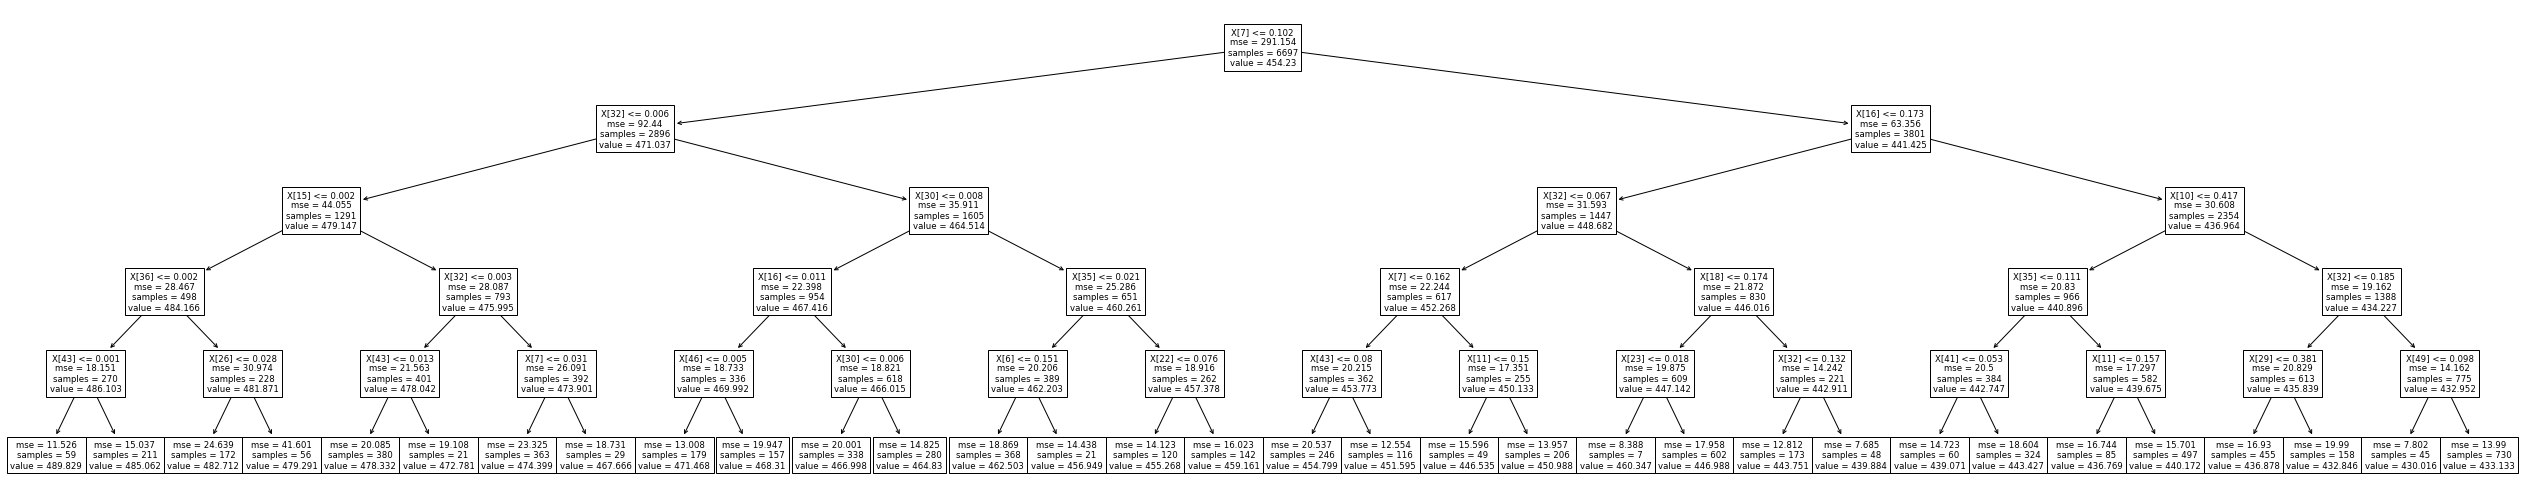

In [7]:
from sklearn import tree
import matplotlib.pyplot as plt
import graphviz 

dt_m1  = DecisionTreeRegressor(criterion='mse',
                              max_depth=5,
                              min_samples_split = 20, 
                              random_state=0)


dt_m1.fit(X_train_sel, y_train[:, np.newaxis]);

f, ax = plt.subplots(figsize=(45, 9))
tree.plot_tree(dt_m1);

dot_data = tree.export_graphviz(dt_m1, out_file=None, 
                                feature_names = ft_names[ft_sel_msk],
                                filled=True, rounded=True,  
                                special_characters=True) 
graph = graphviz.Source(dot_data) 

---
### 1.4. Predicción con los modelos entrenados sobre el conjunto de PRUEBA


In [8]:
model_pl.fit(X_train, y_train[:, np.newaxis])
model_knn.fit(X_train, y_train[:, np.newaxis])
model_dt.fit(X_train, y_train[:, np.newaxis]);

# #--------
# ### PREDICT TEST DATA 

y_hat = model_pl.predict(X_test)
y_hatknn = model_knn.predict(X_test)
y_hatdt = model_dt.predict(X_test)

# #--------
# ### PRINT SCORES

print('TEST ERROR----')

print('LR R2: ',r2_score(y_test,y_hat))
print('KNN R2: ',r2_score(y_test,y_hatknn))
print('DT R2: ',r2_score(y_test,y_hatdt))

print('LR RMSE: ',mean_squared_error(y_test,y_hat, squared=False), 'MW')
print('KNN RMSE: ',mean_squared_error(y_test,y_hatknn, squared=False), 'MW')
print('DT RMSE: ',mean_squared_error(y_test,y_hatdt, squared=False), 'MW')

TEST ERROR----
LR R2:  0.9440331462691587
KNN R2:  0.9531937358196361
DT R2:  0.9350742028625183
LR RMSE:  4.037980644460475 MW
KNN RMSE:  3.6927573916526137 MW
DT RMSE:  4.349180494407878 MW


---
### 1.5. Análisis de Resultados usando Gráficas Q-Q 

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set();

from seaborn_qqplot import pplot

#--------
### GRAPH QQPLOTS

x_plt = np.linspace(1, y_hat.shape[0], y_hat.shape[0])
mod_res = np.hstack((x_plt[:,np.newaxis],
                     y_test[:,np.newaxis],
                     y_hat,
                     y_hatknn,
                     y_hatdt[:,np.newaxis])) 

mod_res_df = pd.DataFrame(mod_res, 
                          columns=['index', 'ytrue','yhatLR', 'yhatKNN', 'yhatDT'])

mod_res_df_mlt = pd.melt(mod_res_df, 
                         id_vars=['ytrue'],
                         value_vars =['yhatLR', 'yhatKNN', 'yhatDT'])

mod_res_df_mlt['variable'] = mod_res_df_mlt['variable'].astype('category')

In [10]:
mod_res_df_mlt

,ytrue,variable,value
0,458.92,yhatLR,458.616239
1,430.55,yhatLR,434.709900
2,473.85,yhatLR,473.844174
3,435.02,yhatLR,435.701664
4,456.44,yhatLR,451.943294
...,...,...,...
8608,442.47,yhatDT,439.883542
8609,472.41,yhatDT,468.309554
8610,479.24,yhatDT,482.711686
8611,435.03,yhatDT,440.171670


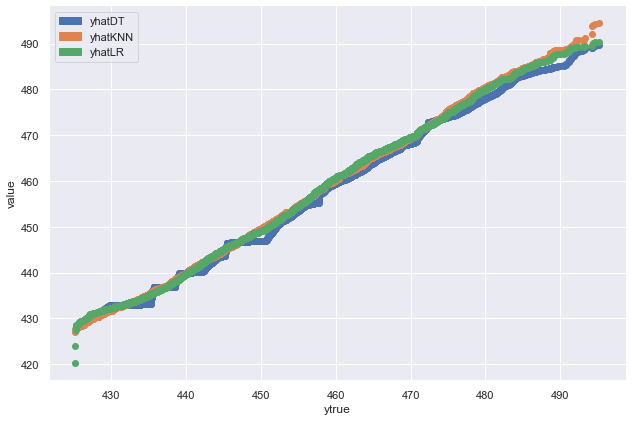

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set();

from seaborn_qqplot import pplot

#--------
### GRAPH QQPLOTS

x_plt = np.linspace(1, y_hat.shape[0], y_hat.shape[0])
mod_res = np.hstack((x_plt[:,np.newaxis],
                     y_test[:,np.newaxis],
                     y_hat,
                     y_hatknn,
                     y_hatdt[:,np.newaxis])) 

mod_res_df = pd.DataFrame(mod_res, 
                          columns=['index', 'ytrue','yhatLR', 'yhatKNN', 'yhatDT'])

mod_res_df_mlt = pd.melt(mod_res_df, 
                         id_vars=['ytrue'],
                         value_vars =['yhatLR', 'yhatKNN', 'yhatDT'])

mod_res_df_mlt['variable'] = mod_res_df_mlt['variable'].astype('category')


pplot(mod_res_df_mlt, x="ytrue", y="value", kind='qq',
       hue = "variable", height = 6, aspect = 1.5,
       display_kws={"identity":True});

---
# 2. Clasificación 

---
## 2.0. Datos Sintéticos

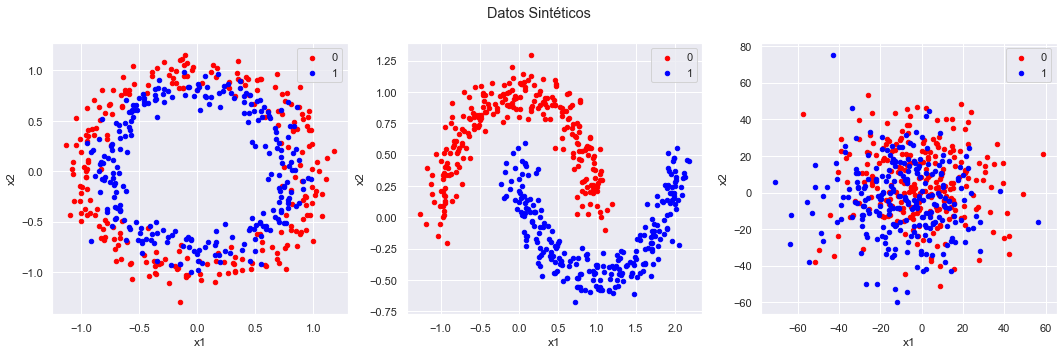

In [12]:
from sklearn.datasets import make_blobs, make_circles, make_moons
from pandas import DataFrame

import matplotlib.pyplot as plt
import seaborn as sns; sns.set();

exp_size = 500

# generate 2d classification dataset
X_circ, y_circ = make_circles(n_samples=exp_size, noise=0.1,
                              random_state=1)
X_moon, y_moon = make_moons(n_samples=exp_size, noise=0.1,
                            random_state=1)

# generate 2d multi classification dataset
X_blob, y_blob = make_blobs(n_samples=exp_size, centers=2, cluster_std= 20,
                            n_features=2,random_state=1)

# scatter plot, dots colored by class value
df_circ = DataFrame(dict(x1 = X_circ[:,0], x2=X_circ[:,1], label=y_circ))
df_moon = DataFrame(dict(x1 = X_moon[:,0], x2=X_moon[:,1], label=y_moon))
colors_bin = {0:'red', 1:'blue'}

df_blob = DataFrame(dict(x1 = X_blob[:,0], x2=X_blob[:,1], label=y_blob))
colors_mult = {0:'red', 1:'blue', 2:'green', 3:'purple'}

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,5))
fig.suptitle('Datos Sintéticos')

grouped = df_circ.groupby('label')
for key, group in grouped:
    group.plot(ax=ax1, kind='scatter', x='x1', y='x2', label=key, color=colors_bin[key])

grouped = df_moon.groupby('label')
for key, group in grouped:
    group.plot(ax=ax2, kind='scatter', x='x1', y='x2', label=key, color=colors_bin[key])

grouped = df_blob.groupby('label')
for key, group in grouped:
    group.plot(ax=ax3, kind='scatter', x='x1', y='x2', label=key, color=colors_mult[key])

---
## 2.1. Clasificación de los Datos Sintéticos

In [13]:
!pip install mlxtend

### 2.1.1. Regresión Logística

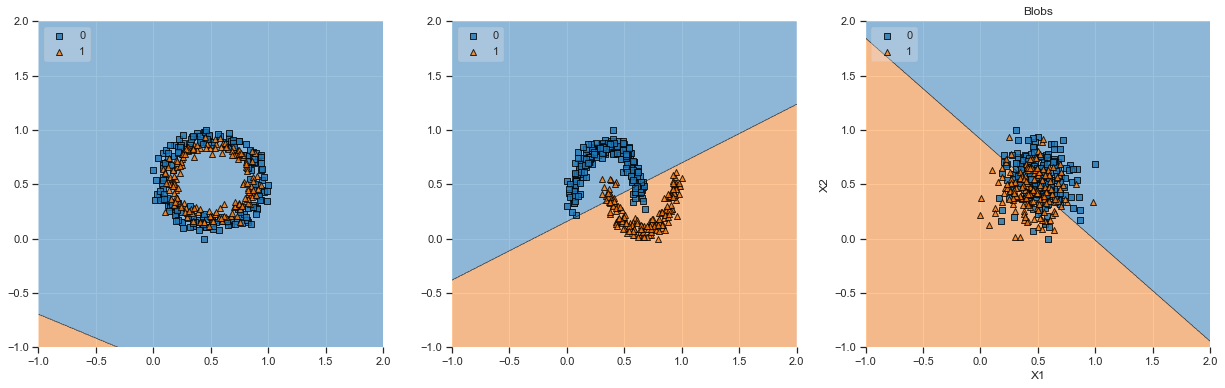

In [14]:
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split

from mlxtend.plotting import plot_decision_regions

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set();

import warnings
warnings.filterwarnings("ignore")

### Initialize PP instances
no_poly = 1
no_sel_fts = 2

sclr_01 = MinMaxScaler()
polyFt_m = PolynomialFeatures(no_poly,include_bias=False)

### Initialize Ft Selection
sel = SelectKBest(chi2, k=no_sel_fts)

fig, axs = plt.subplots(1,3,figsize=(21,6))

### Initialize Model
model = LogisticRegression()

### Block 1 -----
X_train, X_test, y_train, y_test = train_test_split(X_circ, y_circ, 
                                                    test_size=0.3, 
                                                    random_state=1)

X_train_tmp = sclr_01.fit_transform(X_train)
X_train_tmp = polyFt_m.fit_transform(X_train_tmp)

X_train_sel = sel.fit_transform(X_train_tmp, y_train)
model.fit(X_train_sel,y_train)

# Plotting decision regions
plot_decision_regions(X_train_sel, y_train, clf=model, legend=2, ax = axs[0]);
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Circles')
### Block 1 -----

### Block 2 -----
X_train, X_test, y_train, y_test = train_test_split(X_moon, y_moon, 
                                                    test_size=0.3, 
                                                    random_state=1)

X_train_tmp = sclr_01.fit_transform(X_train)
X_train_tmp = polyFt_m.fit_transform(X_train_tmp)

X_train_sel = sel.fit_transform(X_train_tmp, y_train)

model.fit(X_train_sel,y_train)

# Plotting decision regions
plot_decision_regions(X_train_sel, y_train, clf=model, legend=2, ax = axs[1]);
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Moons')
### Block 2 -----

### Block 3 -----
X_train, X_test, y_train, y_test = train_test_split(X_blob, y_blob, 
                                                    test_size=0.3, 
                                                    random_state=1)
X_train_tmp = sclr_01.fit_transform(X_train)
X_train_tmp = polyFt_m.fit_transform(X_train_tmp)

X_train_sel = sel.fit_transform(X_train_tmp, y_train)

model.fit(X_train_sel,y_train)

# Plotting decision regions
plot_decision_regions(X_train_sel, y_train, clf=model, legend=2, ax = axs[2]);
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Blobs')
### Block 3 -----

plt.show();

### 2.1.2. Árbol de Decisión

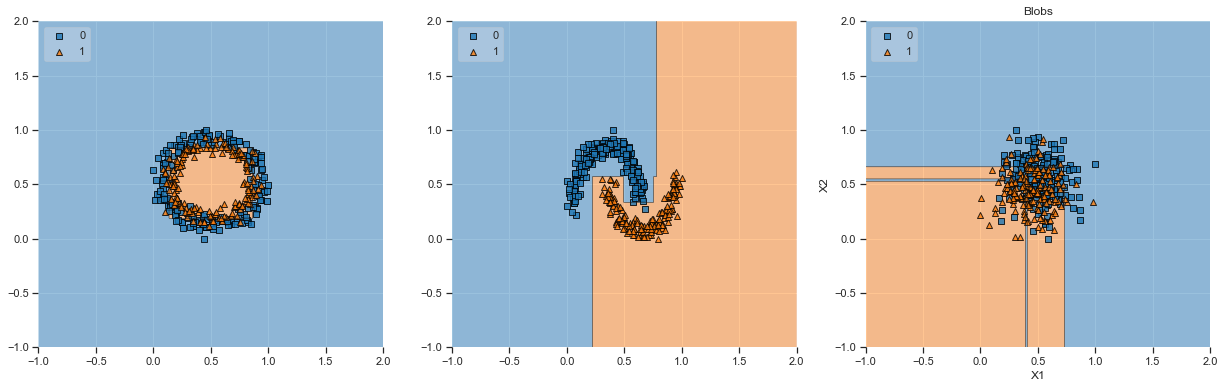

In [15]:
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split

from mlxtend.plotting import plot_decision_regions

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set();

import warnings
warnings.filterwarnings("ignore")

### Initialize PP instances
no_poly = 1
no_sel_fts = 2

sclr_01 = MinMaxScaler()
polyFt_m = PolynomialFeatures(no_poly,include_bias=False)

### Initialize Ft Selection
sel = SelectKBest(chi2, k=no_sel_fts)

### Initialize Model
model = DecisionTreeClassifier(criterion='entropy',
                               max_depth=5,
                               min_samples_split = 20, 
                               random_state=0)

### Initialize Figs
fig, axs = plt.subplots(1,3,figsize=(21,6))

### Block 1 -----
X_train, X_test, y_train, y_test = train_test_split(X_circ, y_circ, 
                                                    test_size=0.3, 
                                                    random_state=1)

X_train_tmp = sclr_01.fit_transform(X_train)
X_train_tmp = polyFt_m.fit_transform(X_train_tmp)

X_train_sel = sel.fit_transform(X_train_tmp, y_train)

model.fit(X_train_sel,y_train)

# Plotting decision regions
plot_decision_regions(X_train_sel, y_train, clf=model, 
                      legend=2, ax = axs[0]);
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Circles')
### Block 1 -----

### Block 2 -----
X_train, X_test, y_train, y_test = train_test_split(X_moon, y_moon, 
                                                    test_size=0.3, 
                                                    random_state=1)

X_train_tmp = sclr_01.fit_transform(X_train)
X_train_tmp = polyFt_m.fit_transform(X_train_tmp)

X_train_sel = sel.fit_transform(X_train_tmp, y_train)

model.fit(X_train_sel,y_train)

# Plotting decision regions
plot_decision_regions(X_train_sel, y_train, clf=model, 
                      legend=2, ax = axs[1]);
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Moons')
### Block 2 -----

### Block 3 -----
X_train, X_test, y_train, y_test = train_test_split(X_blob, y_blob, 
                                                    test_size=0.3, 
                                                    random_state=1)
X_train_tmp = sclr_01.fit_transform(X_train)
X_train_tmp = polyFt_m.fit_transform(X_train_tmp)

X_train_sel = sel.fit_transform(X_train_tmp, y_train)

model.fit(X_train_sel,y_train)

# Plotting decision regions
plot_decision_regions(X_train_sel, y_train, clf=model,
                      legend=2, ax = axs[2]);
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Blobs')
### Block 3 -----

plt.show();

### 2.1.3. K-Vecinos Cercanos

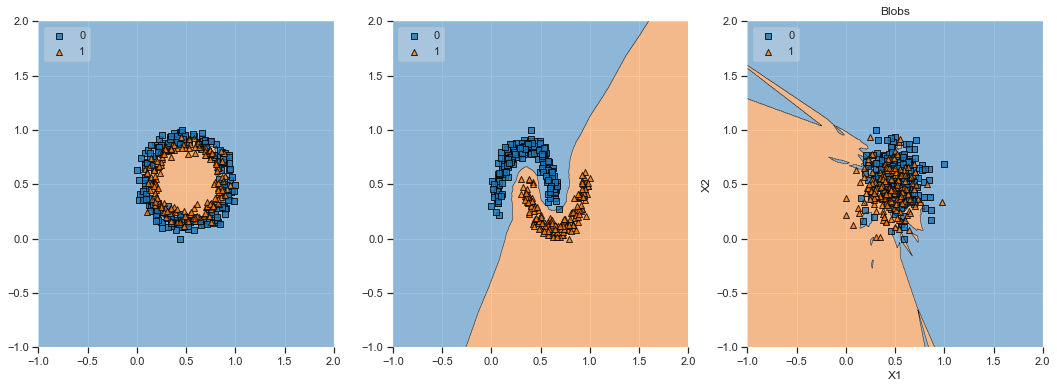

In [16]:
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split

from mlxtend.plotting import plot_decision_regions

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set();

import warnings
warnings.filterwarnings("ignore")

### Initialize PP instances
no_poly = 1
no_sel_fts = 2

sclr_01 = MinMaxScaler()
polyFt_m = PolynomialFeatures(no_poly,include_bias=False)

### Initialize Ft Selection
sel = SelectKBest(chi2, k=no_sel_fts)

### Initialize Model
model = KNeighborsClassifier(n_neighbors=5)

fig, axs = plt.subplots(1,3,figsize=(18,6))

### Block 1 -----
X_train, X_test, y_train, y_test = train_test_split(X_circ, y_circ, 
                                                    test_size=0.3, 
                                                    random_state=1)

X_train_tmp = sclr_01.fit_transform(X_train)
X_train_tmp = polyFt_m.fit_transform(X_train_tmp)

X_train_sel = sel.fit_transform(X_train_tmp, y_train)

model.fit(X_train_sel,y_train)

# Plotting decision regions
plot_decision_regions(X_train_sel, y_train, clf=model,
                      legend=2, ax = axs[0]);
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Circles')
### Block 1 -----

### Block 2 -----
X_train, X_test, y_train, y_test = train_test_split(X_moon, y_moon, 
                                                    test_size=0.3, 
                                                    random_state=1)

X_train_tmp = sclr_01.fit_transform(X_train)
X_train_tmp = polyFt_m.fit_transform(X_train_tmp)

X_train_sel = sel.fit_transform(X_train_tmp, y_train)

model.fit(X_train_sel,y_train)

# Plotting decision regions
plot_decision_regions(X_train_sel, y_train, clf=model,
                      legend=2, ax = axs[1]);
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Moons')
### Block 2 -----

### Block 3 -----
X_train, X_test, y_train, y_test = train_test_split(X_blob, y_blob, 
                                                    test_size=0.3, 
                                                    random_state=1)
X_train_tmp = sclr_01.fit_transform(X_train)
X_train_tmp = polyFt_m.fit_transform(X_train_tmp)

X_train_sel = sel.fit_transform(X_train_tmp, y_train)

model.fit(X_train_sel,y_train)

# Plotting decision regions
plot_decision_regions(X_train_sel, y_train, clf=model,
                      legend=2, ax = axs[2]);
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Blobs')
### Block 3 -----

plt.show();

---
### Evaluación de Clasificadores: 

#### a) Matriz de Confusión

<img src="https://docs.google.com/uc?export=download&id=1u_i_kvdUCeB5pykkGkjRcJwaRbHPVkIR" width="900" align="middle">

<AxesSubplot:xlabel='x1', ylabel='x2'>

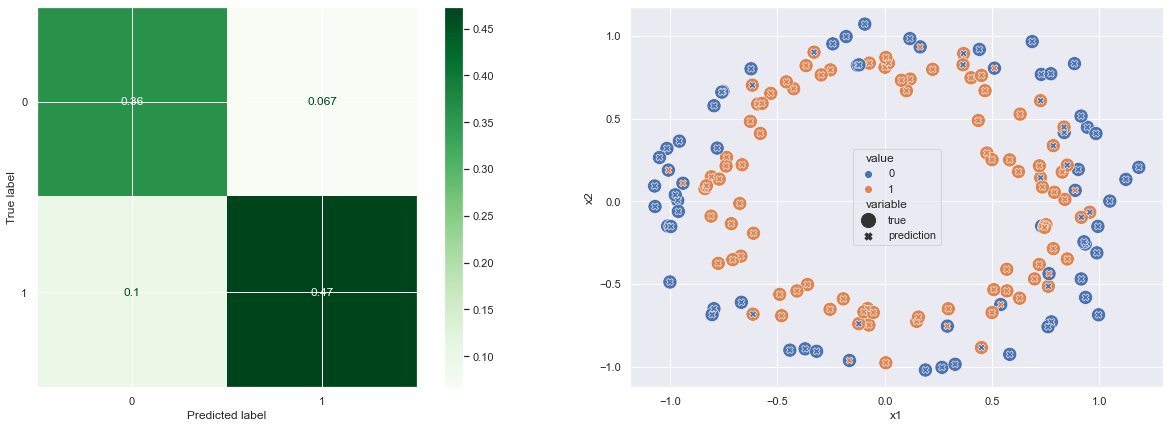

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split

from sklearn.metrics import plot_confusion_matrix

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set();

X_train, X_test, y_train, y_test = train_test_split(X_circ, y_circ, 
                                                    test_size=0.3, 
                                                    random_state=1)

# X_train, X_test, y_train, y_test = train_test_split(X_moon, y_moon, 
#                                                     test_size=0.3, 
#                                                     random_state=1)

# X_train, X_test, y_train, y_test = train_test_split(X_blob, y_blob, 
#                                                     test_size=0.3, 
#                                                     random_state=1)

# model = LogisticRegression()
# model = DecisionTreeClassifier(criterion='entropy',
#                                max_depth=5,
#                                min_samples_split = 20, 
#                                random_state=0)
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train,y_train)

# make a prediction
yhat = model.predict(X_test)

res_df = pd.DataFrame({'x1': X_test[:,0],
                         'x2': X_test[:,1],  
                         'true': y_test[:],
                         'prediction': yhat[:]})

res_df_mlt = pd.melt(res_df,
                       id_vars=['x1','x2'],
                       value_vars=['true', 'prediction'])

# print(res_df_mlt.head())

fig, axs = plt.subplots(1,2,figsize=(21,7))
disp = plot_confusion_matrix(model, X_test, y_test,
                            #  display_labels=['1','0'],
                             cmap=plt.cm.Greens,ax=axs[0], normalize = 'all'
                            )

sns.scatterplot(x="x1", y="x2", hue="value", style= 'variable', size='variable', sizes=[200,50],
                     data=res_df_mlt, ax=axs[1])

---
## 2.2. Usos de la Validación Cruzada para Clasificación

<img src="https://docs.google.com/uc?export=download&id=1SYRmAT3I0Qlrwl6kauBqOBlwfhEzMEWG" width="500" align="middle">

### 2.2.1. Como métrica de error en la Selección de Variables Recursivas

Optimal number of features : 5


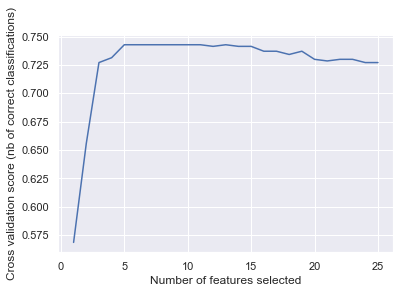

0.7566666666666667


In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score

from sklearn.datasets import make_classification

import matplotlib.pyplot as plt

# Build a classification task using N informative features
X_rand, y_rand = make_classification(n_samples=1000, 
                                     n_features=25, 
                                     n_informative=3,
                                     n_redundant=16, n_repeated=4, 
                                     n_classes=2, class_sep=0.2,
                                     n_clusters_per_class=1, random_state=0)

# Create the RFE object and compute a cross-validated score.
model = LogisticRegression()
# model = DecisionTreeClassifier(criterion='entropy',
#                                max_depth=5,
#                                min_samples_split = 20, 
#                                random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X_rand, y_rand, 
                                                    test_size=0.3, 
                                                    random_state=1)

# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=model, step=1, cv=10,
              scoring='accuracy')
rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

X_train_rfecv = rfecv.fit_transform(X_train, y_train)
model.fit(X_train_rfecv, y_train)

X_test_rfecv = rfecv.transform(X_test)
yhat = model.predict(X_test_rfecv)

print(accuracy_score(y_test, yhat))

### 2.2.2. Sintonización de Parámetros 

#### a) Búsqueda en Malla (GridSearch)

In [19]:
from sklearn.datasets import load_iris
from sklearn.datasets import load_breast_cancer
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score,classification_report

import numpy as np


# iris = load_iris()
# X, y = load_iris(return_X_y=True);
X, y = load_breast_cancer(return_X_y=True);

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=1)


# Set the parameters by cross-validation
tuned_parameters = [{'n_neighbors': np.arange(2, 10, 1), 
                     'p': [1, 2]},
                    {'n_neighbors': [2,5,10,20],
                     'algorithm': ['kd_tree'],
                     'leaf_size': [20, 30,40]}]


clf = GridSearchCV(KNeighborsClassifier(),
                   tuned_parameters, 
                   scoring='accuracy')
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print("Predict:")
print()
y_true, y_hat = y_test, clf.predict(X_test)
print(accuracy_score(y_true, y_hat))
print()
print(classification_report(y_true, y_hat))

Best parameters set found on development set:

{'n_neighbors': 9, 'p': 1}

Grid scores on development set:

0.912 (+/-0.015) for {'n_neighbors': 2, 'p': 1}
0.900 (+/-0.054) for {'n_neighbors': 2, 'p': 2}
0.920 (+/-0.051) for {'n_neighbors': 3, 'p': 1}
0.905 (+/-0.051) for {'n_neighbors': 3, 'p': 2}
0.915 (+/-0.064) for {'n_neighbors': 4, 'p': 1}
0.897 (+/-0.069) for {'n_neighbors': 4, 'p': 2}
0.920 (+/-0.058) for {'n_neighbors': 5, 'p': 1}
0.905 (+/-0.070) for {'n_neighbors': 5, 'p': 2}
0.925 (+/-0.067) for {'n_neighbors': 6, 'p': 1}
0.907 (+/-0.066) for {'n_neighbors': 6, 'p': 2}
0.920 (+/-0.064) for {'n_neighbors': 7, 'p': 1}
0.910 (+/-0.068) for {'n_neighbors': 7, 'p': 2}
0.920 (+/-0.066) for {'n_neighbors': 8, 'p': 1}
0.912 (+/-0.063) for {'n_neighbors': 8, 'p': 2}
0.930 (+/-0.038) for {'n_neighbors': 9, 'p': 1}
0.922 (+/-0.058) for {'n_neighbors': 9, 'p': 2}
0.900 (+/-0.054) for {'algorithm': 'kd_tree', 'leaf_size': 20, 'n_neighbors': 2}
0.905 (+/-0.070) for {'algorithm': 'kd_tree